In [45]:
import json
import csv
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from datetime import datetime

In [46]:
#Se lee la data entera
with open('../data/subreddits.json', 'r') as file:
    data = json.load(file)

In [47]:
#Dataframe para los subreddits
subreddit_data = pd.DataFrame({
    'subreddit_id': range(len(data)),  #Se crea un id para cada subreddit
    'tittleSubreddit': [sub['tittleSubreddit'] for sub in data],
    'subscribersReddit': [sub['subscribersReddit'] for sub in data],
    'descriptionReddit': [sub['descriptionReddit'] for sub in data],
    'createdReddit': [sub['createdReddit'] for sub in data],
})

#Dataframe para los posts
posts_data = []
for i, sub in enumerate(data):
    for post in sub['upVotedPosts']:
        posts_data.append({
            'subreddit_id': i,  #foreign key
            'titlePost': post['titlePost'],
            'selftext': post['selftext'],
            'createdPost': post['createdPost'],
            'scorePost': post['scorePost'],
            'upVotedRatio': post['upVotedRatio'],
            'upVotes': post['upVotes'],
            'commentsPost': post['commentsPost'],
        })

posts_data = pd.DataFrame(posts_data)

In [48]:
subreddit_data.head()

,subreddit_id,tittleSubreddit,subscribersReddit,descriptionReddit,createdReddit
0,0,Home,243743,,1.232850e+09
1,1,AskReddit,48481312,r/AskReddit is the place to ask and answer tho...,1.201233e+09
2,2,NoStupidQuestions,4980890,Ask away!\n\nDisclaimer: This is an anonymous ...,1.359795e+09
3,3,BaldursGate3,2364982,"A community all about Baldur's Gate III, the r...",1.559227e+09
4,4,facepalm,8265075,/r/facepalm - please sir can I have some more?,1.251449e+09


In [49]:
posts_data.head()

,subreddit_id,titlePost,selftext,createdPost,scorePost,upVotedRatio,upVotes,commentsPost
0,0,What is the price range for a house like this?,,1.692354e+09,11633,0.92,11633,1727
1,0,Why is there a door above the garage?,It has a porch light. There’s a door knob and ...,1.684428e+09,6026,0.96,6026,1700
2,0,Can I fix these garage door torsion springs by...,Wdyt about me replacing this pair by myself?,1.693079e+09,5581,0.86,5581,3644
3,0,What you call these types of designs,,1.692639e+09,2824,0.96,2824,579
4,0,An inspector said this is termite damage and m...,,1.690566e+09,2692,0.94,2692,952


**Procesamiento subreddits**

In [50]:
#Cambiamos el formato de las fechas en posts_data a datetime
posts_data['createdPost'] = pd.to_datetime(posts_data['createdPost'], unit='s')
subreddit_data['createdReddit'] = pd.to_datetime(subreddit_data['createdReddit'], unit='s')
#Debido a que pocos registros tienen la descripción vacía, se puede asumir su uso.
numNulls = (subreddit_data["descriptionReddit"] == "").sum()
numNulls 

1

***Procesamiento posts***

In [51]:
#Se elimina la columna 'selftext' debido alto porcentage de vacios
numNulls = (posts_data["selftext"] == "").sum()
percentage = numNulls / len(posts_data["selftext"]) * 100

print("Total de registros en la columna 'selftext':", len(posts_data["selftext"]))
print("Porcentaje de registros vacios en la columna 'selftext':", percentage, "%")
posts_data = posts_data.drop(columns=["selftext"])

Total de registros en la columna 'selftext': 30000
Porcentaje de registros vacios en la columna 'selftext': 72.92999999999999 %


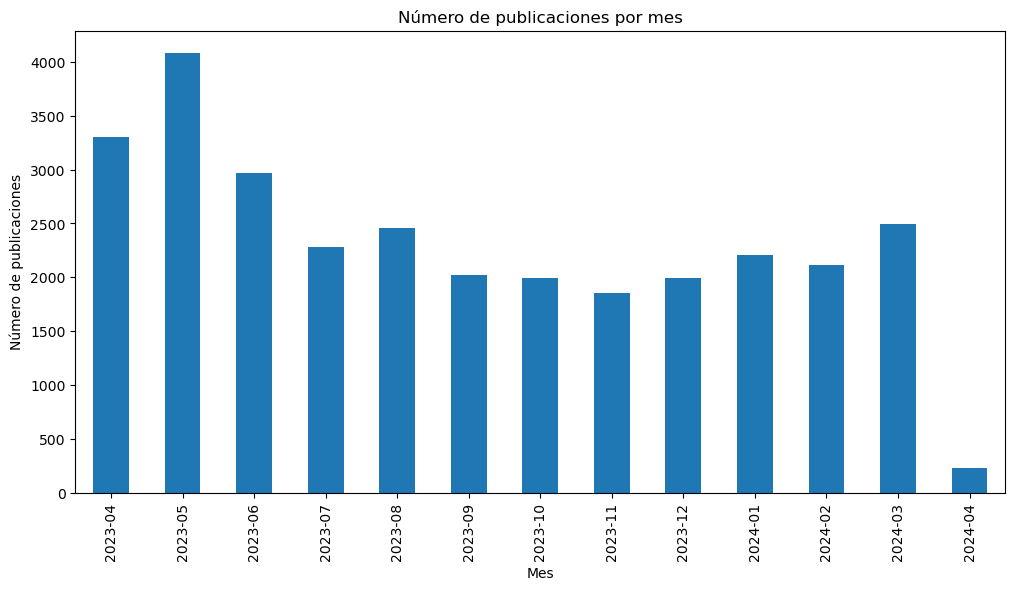

In [52]:
postsMonth = posts_data['createdPost'].dt.to_period('M').value_counts().sort_index()
date_range = pd.period_range(start=postsMonth.index.min(), end=postsMonth.index.max(), freq='M')
postsMonth = postsMonth.reindex(date_range, fill_value=0)

plt.figure(figsize=(12, 6))
postsMonth.plot(kind='bar')
plt.title('Número de publicaciones por mes')
plt.xlabel('Mes')
plt.ylabel('Número de publicaciones')
plt.show()

In [53]:
subreddit_data.to_csv('../data/subreddit_data.csv', index=False)
posts_data.to_csv('../data/posts_data.csv', index=False)